In [1]:
# COCO classes
CLASSES = [
    'person', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'truck', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A2',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'cow',
    'sheep', 'cow', 'zebra', 'giraffe', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A3', 'N/A4', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'skateboard', 'sports ball', 'kite', 'baseball bat', 'wine glass',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'bowl', 'wine glass',
    'cup', 'fork', 'orange', 'broccoli', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A6', 'dining table', 'N/A7',
    'N/A8', 'toilet', 'N/A9', 'tv', 'laptop', 'clock', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A10',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

coco_idx_to_label = {idx: label for idx, label in enumerate(CLASSES)}

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]



In [2]:
import torch
import matplotlib.pyplot as plt
import torchvision

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        output_tensor = []
        for t, m, s in zip(tensor, self.mean, self.std):
            output_tensor.append(t.mul(s).add(m))
            # t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return torch.stack(output_tensor, dim=0)

unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(img, labels, boxes, mask=None, classes=CLASSES):
    h, w = img.shape[1:]
    if mask != None:
        # width
        if torch.where(mask[0])[0].shape[0] > 0:
            mask_w = torch.where(mask[0])[0][0]
            w = min(w, mask_w)
        if torch.where(mask[:, 0])[0].shape[0]:
            mask_h = torch.where(mask[:, 0])[0][0]
            h = min(h, mask_h)
            
    boxes = rescale_bboxes(boxes, (w, h))
    plt.figure(figsize=(16,10))
    #unimage = unnorm(img)
    #image = (unimage*256).to(torch.uint8)
    #image = unimage
    image = img
    pil_img = torchvision.transforms.functional.to_pil_image(image)
    plt.imshow(pil_img)
    
    ax = plt.gca()
    colors = COLORS * 100
    for label, (xmin, ymin, xmax, ymax), c in zip(labels, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{classes[label.item()]}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

/traindata/maksim/miniconda3/envs/rtdetr/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
from argparse import Namespace
args = Namespace(config='configs/rtdetr/rtdetr_r50vd_6x_coco.yml', resume=None, tuning=None, test_only=False, amp=False, seed=None)

In [4]:
import os 
import sys
import argparse

import src.misc.dist as dist 
from src.core import YAMLConfig 
from src.solver import TASKS

dist.init_distributed()
if args.seed is not None:
    dist.set_seed(args.seed)

assert not all([args.tuning, args.resume]), \
    'Only support from_scrach or resume or tuning at one time'

cfg = YAMLConfig(
    args.config,
    resume=args.resume, 
    use_amp=args.amp,
    tuning=args.tuning
)

solver = TASKS[cfg.yaml_cfg['task']](cfg)

/traindata/maksim/miniconda3/envs/rtdetr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Not init distributed mode.


In [5]:
solver.cfg.epochs = 0

In [8]:
solver.setup()
solver.train()

Initial lr:  [1e-05, 0.0001, 0.0001, 0.0001]
loading annotations into memory...
Done (t=13.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [9]:
solver.train_dataloader.dataset

Dataset CocoDetection
    Number of datapoints: 118287
    Root location: /traindata/maksim/datasets/coco/train2017/
     img_folder: /traindata/maksim/datasets/coco/train2017/
     ann_file: /traindata/maksim/datasets/coco/annotations/instances_train2017.json
     return_masks: False
     transforms:
       Compose(
          RandomZoomOut(p=0.5, fill=0, side_range=(1.0, 4.0))
          RandomIoUCrop(min_scale=0.3, max_scale=1, min_aspect_ratio=0.5, max_aspect_ratio=2, options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0], trials=40, p=0.8)
          SanitizeBoundingBox(min_size=1, labels_getter=default)
          RandomHorizontalFlip(p=0.5)
          Resize(size=[640, 640], interpolation=InterpolationMode.BILINEAR, antialias=warn)
          ToImageTensor()
          ConvertDtype()
          SanitizeBoundingBox(min_size=1, labels_getter=default)
          ConvertBox(out_fmt=cxcywh, normalize=True)
    )

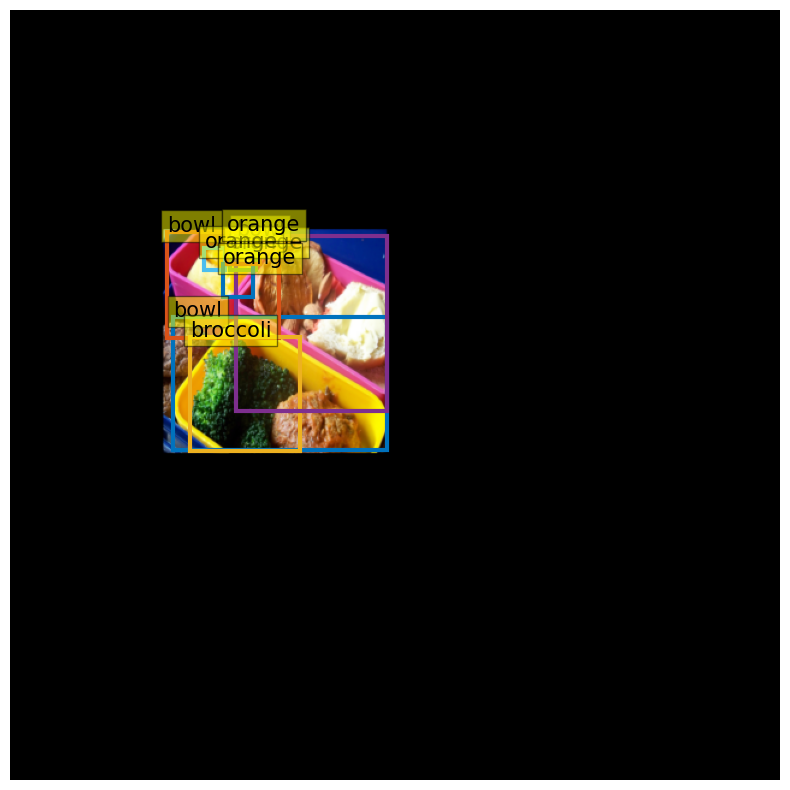

In [10]:
sample = solver.train_dataloader.dataset[0]
plot_results(sample[0], sample[1]["labels"], sample[1]["boxes"], classes=CLASSES)

In [11]:
for batch in solver.train_dataloader:
    break
batch

(tensor([[[[0.2118, 0.2118, 0.2275,  ..., 0.8196, 0.8235, 0.8235],
           [0.2118, 0.2118, 0.2275,  ..., 0.8196, 0.8235, 0.8235],
           [0.2118, 0.2118, 0.2275,  ..., 0.8196, 0.8235, 0.8235],
           ...,
           [0.2196, 0.2196, 0.2196,  ..., 0.1098, 0.1059, 0.1059],
           [0.2196, 0.2196, 0.2196,  ..., 0.1098, 0.1059, 0.1059],
           [0.2196, 0.2196, 0.2196,  ..., 0.1098, 0.1059, 0.1059]],
 
          [[0.2196, 0.2196, 0.2392,  ..., 0.9294, 0.9294, 0.9294],
           [0.2196, 0.2196, 0.2392,  ..., 0.9294, 0.9294, 0.9294],
           [0.2196, 0.2196, 0.2392,  ..., 0.9294, 0.9294, 0.9294],
           ...,
           [0.2157, 0.2157, 0.2196,  ..., 0.0667, 0.0627, 0.0627],
           [0.2157, 0.2157, 0.2196,  ..., 0.0667, 0.0627, 0.0627],
           [0.2157, 0.2157, 0.2196,  ..., 0.0667, 0.0627, 0.0627]],
 
          [[0.2784, 0.2784, 0.2980,  ..., 0.8549, 0.8549, 0.8549],
           [0.2784, 0.2784, 0.2980,  ..., 0.8549, 0.8549, 0.8549],
           [0.2784, 0.27

In [12]:
batch[0].shape

torch.Size([4, 3, 640, 640])

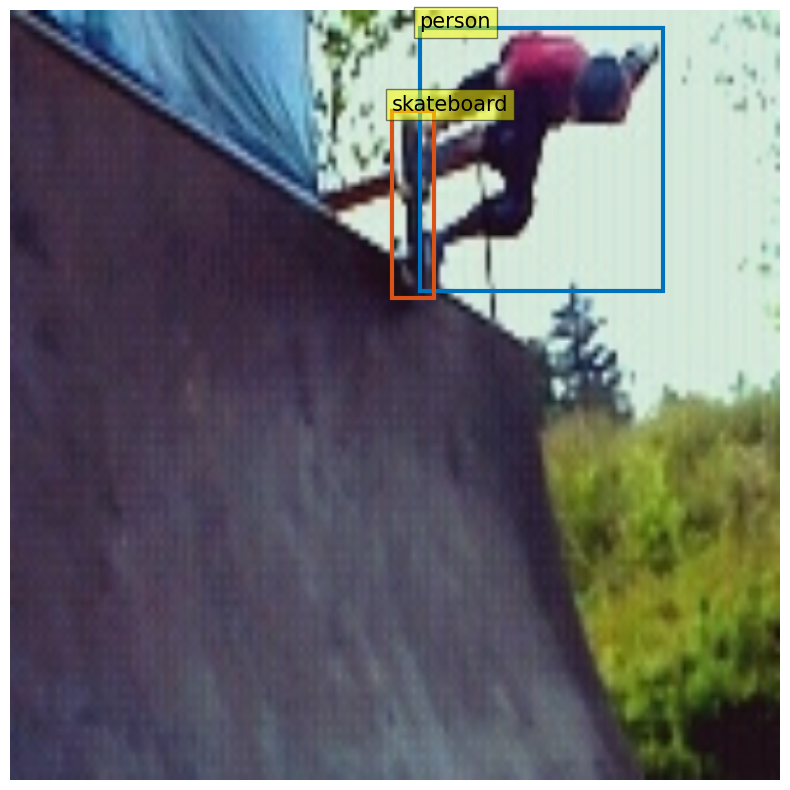

In [13]:
batch_idx = 0
plot_results(batch[0][batch_idx], batch[1][batch_idx]["labels"], batch[1][batch_idx]["boxes"], classes=CLASSES)

In [14]:
preds = solver.model(batch[0], batch[1])
preds

{'pred_logits': tensor([[[-4.2616, -6.7749, -5.1791,  ..., -6.0304, -4.3428, -3.6245],
          [-4.6885, -6.6095, -4.9162,  ..., -5.4832, -4.0862, -4.7054],
          [-3.8260, -6.1534, -4.7456,  ..., -4.7765, -5.5785, -4.4078],
          ...,
          [-4.4014, -5.1290, -3.7004,  ..., -4.1689, -4.6089, -3.6954],
          [-5.2703, -5.9437, -4.0033,  ..., -5.7212, -5.3173, -4.0936],
          [-4.4932, -5.3260, -4.3844,  ..., -5.6146, -4.6681, -4.9638]],
 
         [[-4.2988, -5.8532, -4.6049,  ..., -5.1207, -4.1976, -3.7854],
          [-4.4163, -5.0121, -4.7496,  ..., -4.3227, -4.3287, -4.3227],
          [-4.3482, -6.2153, -4.6243,  ..., -4.7858, -3.8552, -4.4067],
          ...,
          [-4.2508, -6.0967, -4.6246,  ..., -4.9469, -3.6256, -4.0970],
          [-5.0566, -6.0711, -4.5050,  ..., -5.3072, -5.0916, -5.0440],
          [-4.7536, -5.6232, -4.7586,  ..., -5.9504, -3.7394, -5.1181]],
 
         [[-4.4408, -4.4091, -4.6406,  ..., -3.8179, -4.3607, -5.2712],
          [-5